In [1]:
import os
import torch
import scipy.io
import torch.nn as nn  # Import nn module
import torch.optim as optim  # Import optim module
import torchvision.models as models
from torch.utils.data import Dataset, DataLoader, random_split
from torchvision import transforms
import matplotlib.pyplot as plt
from hyperspectral_dataset import HyperspectralDataset, compute_statistics, NormalizeCube, NormalizeProfile
from rgb_dataset import RGBDataset
from torchvision.transforms import Resize, CenterCrop, Compose, Normalize, ToTensor
from transformers import AutoImageProcessor, AutoModelForImageClassification




from ResNet import CustomResNet50  # Assuming ResNet50 is defined in ResNet.py
import torch
print(torch.cuda.is_available())  # Should return True
print(torch.cuda.get_device_name(0))  # Should print the name of your GPU
# Check for CUDA
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)



device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

# Create a random tensor and move it to the GPU
x = torch.rand(10000, 10000).to(device)
y = torch.rand(10000, 10000).to(device)

# Perform a matrix multiplication on the GPU
z = torch.matmul(x, y)

print("Matrix multiplication result:", z)
print("Done.")



Original x:  tensor([-2.9014, -0.0911,  1.3566,  0.5976, -0.3257,  0.3141,  1.1275, -0.2164,
         0.7639, -0.0141])
Reconstructed x:  tensor([-2.9014, -0.0911,  1.3566,  0.5976, -0.3257,  0.3141,  1.1275, -0.2164,
         0.7639, -0.0141])
Difference:  tensor(3.7616e-07)
True
NVIDIA GeForce RTX 4070
Using device: cuda
Using device: cuda
Matrix multiplication result: tensor([[2503.0649, 2517.9666, 2499.4458,  ..., 2517.6455, 2522.7876,
         2502.5994],
        [2492.2927, 2510.9028, 2500.0759,  ..., 2499.6792, 2513.9778,
         2478.8840],
        [2499.2803, 2497.0703, 2514.0398,  ..., 2498.7942, 2512.3462,
         2513.0947],
        ...,
        [2514.7087, 2518.8069, 2515.7798,  ..., 2528.7097, 2514.0063,
         2500.0945],
        [2494.5747, 2476.5330, 2489.3442,  ..., 2511.2207, 2500.4634,
         2489.4084],
        [2484.9104, 2489.5828, 2478.9109,  ..., 2491.7778, 2486.0774,
         2484.5493]], device='cuda:0')
Done.


In [2]:
# Function to get all file paths from a dataset
def get_all_file_paths(dataset):
    file_paths = []
    # for idx in range(len(dataset)):
    file_paths.append(dataset.get_image_path(idx))
    return file_paths

# # Initialize the dataset with transformations
# dataset = RGBDataset(root_dir='../../../serverstuff/hsi/all')
# channel_means_cube, channel_stds_cube, channel_means_profile, channel_stds_profile = compute_statistics(dataset)
feature_extractor = AutoImageProcessor.from_pretrained("facebook/convnextv2-base-1k-224", ignore_mismatched_sizes=True)
normalize = Normalize(mean=feature_extractor.image_mean, std=feature_extractor.image_std)
transform = transforms.Compose([Resize((256, 256)), CenterCrop((256, 256)), ToTensor(), normalize])

# Apply the custom transforms to the datasets
train_dataset = RGBDataset(root_dir='../../../serverstuff/hsi/train', transform=transform)
val_dataset = RGBDataset(root_dir='../../../serverstuff/hsi/validation', transform=transform)
test_dataset = RGBDataset(root_dir='../../../serverstuff/hsi/test', transform=transform)

# Create DataLoaders for training, validation, and test sets
train_loader = DataLoader(train_dataset, batch_size=4, shuffle=True, num_workers=4)
val_loader = DataLoader(val_dataset, batch_size=4, shuffle=False, num_workers=4)
test_loader = DataLoader(test_dataset, batch_size=4, shuffle=False, num_workers=4)

Label mapping: {'Acinetobacter_baumanii': 0, 'Lactobacillus_casei': 1, 'Lactobacillus_jehnsenii': 2, 'Lactobacillus_gasseri': 3, 'Lactobacillus_delbrueckii': 4, 'Lactobacillus_salivarius': 5, 'Propionibacterium_acnes': 6, 'Lactobacillus_paracasei': 7, 'Bifidobacterium_spp': 8, 'Lactobacillus_reuteri': 9, 'Staphylococcus_aureus': 10, 'Escherichia_coli': 11, 'Lactobacillus_rhamnosus': 12, 'Lactobacillus_plantarum': 13, 'Enterococcus_faecium': 14, 'Porfyromonas_gingivalis': 15, 'Enterococcus_faecalis': 16, 'Micrococcus_spp': 17, 'Fusobacterium': 18, 'Actinomyces_israeli': 19, 'Lactobacillus_crispatus': 20, 'Clostridium_perfringens': 21, 'Staphylococcus_epidermidis': 22, 'Listeria_monocytogenes': 23, 'Pseudomonas_aeruginosa': 24, 'Lactobacillus_johnsonii': 26, 'Streptococcus_agalactiae': 27, 'Staphylococcus_saprophiticus': 28, 'Bacteroides_fragilis': 29, 'Neisseria_gonorrhoeae': 30, 'Veionella': 31, 'Proteus': 32, 'Candida_albicans': 33}
Label mapping: {'Acinetobacter_baumanii': 0, 'Lactob

In [3]:
# # Function to get all file paths from a dataset
# def get_all_file_paths(dataset):
#     file_paths = []
#     for idx in range(len(dataset)):
#         file_paths.append(dataset.get_image_path(idx))
#     return file_paths

# # # Initialize the dataset with transformations
# dataset = HyperspectralDataset(root_dir='../../dibasRP/all')
# # channel_means_cube, channel_stds_cube, channel_means_profile, channel_stds_profile = compute_statistics(dataset)

# channel_means_cube, channel_stds_cube, channel_means_profile, channel_stds_profile = [0.5] * 31, [0.5] * 31, [0.5] * 31, [0.5] * 31
# # Define the custom transformations using the computed statistics
# cube_transform = NormalizeCube(mean=channel_means_cube, std=channel_stds_cube)
# profile_transform = NormalizeProfile(mean=channel_means_profile, std=channel_stds_profile)

# # Apply the custom transforms to the datasets
# train_dataset = HyperspectralDataset(root_dir='../../dibasRP/train', cube_transform=cube_transform)
# val_dataset = HyperspectralDataset(root_dir='../../dibasRP/val', cube_transform=cube_transform)
# test_dataset = HyperspectralDataset(root_dir='../../dibasRP/test', cube_transform=cube_transform)

# # Create DataLoaders for training, validation, and test sets
# train_loader = DataLoader(train_dataset, batch_size=4, shuffle=True, num_workers=4)
# val_loader = DataLoader(val_dataset, batch_size=4, shuffle=False, num_workers=4)
# test_loader = DataLoader(test_dataset, batch_size=4, shuffle=False, num_workers=4)

In [4]:
# # Get file paths for the main dataset and each split
# main_dataset_paths = get_all_file_paths(dataset)
# train_dataset_paths = get_all_file_paths(train_dataset)
# val_dataset_paths = get_all_file_paths(val_dataset)
# test_dataset_paths = get_all_file_paths(test_dataset)

# # Check if the total length of the splits equals the length of the main dataset
# total_split_length = len(train_dataset_paths) + len(val_dataset_paths) + len(test_dataset_paths)
# if total_split_length != len(main_dataset_paths):
#     print(f"Error: Total length of splits ({total_split_length}) does not equal length of main dataset ({len(main_dataset_paths)})")
# else:
#     print("Total length of splits matches the length of the main dataset.")

# # Check for overlaps between splits
# def check_for_overlaps(paths1, paths2):
#     overlaps = set(paths1) & set(paths2)
#     return overlaps

# train_val_overlaps = check_for_overlaps(train_dataset_paths, val_dataset_paths)
# train_test_overlaps = check_for_overlaps(train_dataset_paths, test_dataset_paths)
# val_test_overlaps = check_for_overlaps(val_dataset_paths, test_dataset_paths)

# if train_val_overlaps:
#     print(f"Error: Overlaps found between train and validation datasets: {len(train_val_overlaps)} overlaps")
# else:
#     print("No overlaps found between train and validation datasets.")

# if train_test_overlaps:
#     print(f"Error: Overlaps found between train and test datasets: {len(train_test_overlaps)} overlaps")
# else:
#     print("No overlaps found between train and test datasets.")

# if val_test_overlaps:
#     print(f"Error: Overlaps found between validation and test datasets: {len(val_test_overlaps)} overlaps")
# else:
#     print("No overlaps found between validation and test datasets.")

In [5]:
# Initialize the modified ResNet model

processor = AutoImageProcessor.from_pretrained("facebook/convnextv2-base-1k-224")
model = AutoModelForImageClassification.from_pretrained("facebook/convnextv2-base-1k-224").to(device)

# model = CustomResNet50(num_classes=len(train_dataset.label_map)).to(device)
# model = models.resnet50(weights=models.ResNet50_Weights.IMAGENET1K_V1).to(device)
for name, param in model.named_parameters():
    param.requires_grad = "classifier" in name

# Get the number of input features of the current classifier layer
num_features = model.classifier.in_features

# Replace the classifier layer with a new one
model.classifier = nn.Linear(num_features, 34).to(device)  # Assuming 10 classes

print(model.classifier.out_features)
    

for name, param in model.named_parameters():
    print(f"{name}: {'requires_grad' if param.requires_grad else 'frozen'}")


34
convnextv2.embeddings.patch_embeddings.weight: frozen
convnextv2.embeddings.patch_embeddings.bias: frozen
convnextv2.embeddings.layernorm.weight: frozen
convnextv2.embeddings.layernorm.bias: frozen
convnextv2.encoder.stages.0.layers.0.dwconv.weight: frozen
convnextv2.encoder.stages.0.layers.0.dwconv.bias: frozen
convnextv2.encoder.stages.0.layers.0.layernorm.weight: frozen
convnextv2.encoder.stages.0.layers.0.layernorm.bias: frozen
convnextv2.encoder.stages.0.layers.0.pwconv1.weight: frozen
convnextv2.encoder.stages.0.layers.0.pwconv1.bias: frozen
convnextv2.encoder.stages.0.layers.0.grn.weight: frozen
convnextv2.encoder.stages.0.layers.0.grn.bias: frozen
convnextv2.encoder.stages.0.layers.0.pwconv2.weight: frozen
convnextv2.encoder.stages.0.layers.0.pwconv2.bias: frozen
convnextv2.encoder.stages.0.layers.1.dwconv.weight: frozen
convnextv2.encoder.stages.0.layers.1.dwconv.bias: frozen
convnextv2.encoder.stages.0.layers.1.layernorm.weight: frozen
convnextv2.encoder.stages.0.layers.1.

In [6]:
# Define the loss function and optimizer
criterion = nn.CrossEntropyLoss()
# optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9, weight_decay=0.0005)
# optimizer = optim.Adam(model.parameters(), lr=0.001)
from transformers import AdamW
optimizer = AdamW(model.parameters(), lr=0.001, weight_decay=0.01)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, factor = 0.5, patience=5)



/home/michael/Desktop/ifile/nn/ResNet-PyTorch/ResNet/venvres/lib/python3.9/site-packages/transformers/optimization.py:591: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


In [7]:
import time
from sklearn.metrics import precision_recall_fscore_support

# Initialize lists to store losses, accuracy, and learning rate change epochs
train_losses = []
val_losses = []
train_accuracies = []
val_accuracies = []
train_precisions = []
train_recalls = []
train_f1_scores = []
val_precisions = []
val_recalls = []
val_f1_scores = []
lr_change_epochs = []

# Training and validation loop
num_epochs = 125  # Set the number of epochs
for epoch in range(num_epochs):
    epoch_start_time = time.time()  # Start timing the epoch

    model.train()  # Set the model to training mode
    running_loss = 0.0
    correct_train = 0
    total_train = 0
    all_train_labels = []
    all_train_preds = []

    for batch_idx, (cubes, labels) in enumerate(train_loader):
        cubes, labels = cubes.to(device), labels.to(device)  # Move data to GPU
        optimizer.zero_grad()  # Zero the parameter gradients

        # Forward pass
        outputs = model(cubes)
        loss = criterion(outputs.logits, labels)

        # Backward pass and optimization
        loss.backward()
        optimizer.step()

        running_loss += loss.item()

        # Calculate training accuracy
        _, predicted = torch.max(outputs.logits, 1)
        total_train += labels.size(0)
        correct_train += (predicted == labels).sum().item()

        # Store labels and predictions for precision, recall, f1
        all_train_labels.extend(labels.cpu().numpy())
        all_train_preds.extend(predicted.cpu().numpy())

    avg_train_loss = running_loss / len(train_loader)
    train_losses.append(avg_train_loss)
    train_accuracy = 100 * correct_train / total_train
    train_accuracies.append(train_accuracy)

    # Calculate precision, recall, f1 score for training
    train_precision, train_recall, train_f1, _ = precision_recall_fscore_support(all_train_labels, all_train_preds, average='weighted')
    train_precisions.append(train_precision)
    train_recalls.append(train_recall)
    train_f1_scores.append(train_f1)
    
    print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {avg_train_loss:.4f}, Training Accuracy: {train_accuracy:.2f}%, Precision: {train_precision:.3f}, Recall: {train_recall:.3f}, F1 Score: {train_f1:.3f}")

    # Validation loop
    model.eval()  # Set the model to evaluation mode
    val_loss = 0.0
    correct_val = 0
    total_val = 0
    all_val_labels = []
    all_val_preds = []

    with torch.no_grad():
        for cubes, labels in val_loader:
            cubes, labels = cubes.to(device), labels.to(device)  # Move data to GPU
            outputs = model(cubes)
            loss = criterion(outputs.logits, labels)
            val_loss += loss.item()

            _, predicted = torch.max(outputs.logits, 1)
            total_val += labels.size(0)
            correct_val += (predicted == labels).sum().item()

            # Store labels and predictions for precision, recall, f1
            all_val_labels.extend(labels.cpu().numpy())
            all_val_preds.extend(predicted.cpu().numpy())

    avg_val_loss = val_loss / len(val_loader)
    val_losses.append(avg_val_loss)
    val_accuracy = 100 * correct_val / total_val
    val_accuracies.append(val_accuracy)

    # Calculate precision, recall, f1 score for validation
    val_precision, val_recall, val_f1, _ = precision_recall_fscore_support(all_val_labels, all_val_preds, average='weighted')
    val_precisions.append(val_precision)
    val_recalls.append(val_recall)
    val_f1_scores.append(val_f1)

    print(f"Validation Loss: {avg_val_loss:.4f}, Validation Accuracy: {val_accuracy:.2f}%, Precision: {val_precision:.3f}, Recall: {val_recall:.3f}, F1 Score: {val_f1:.3f}")

    current_lr = optimizer.param_groups[0]['lr']
    scheduler.step(avg_val_loss)
    new_lr = optimizer.param_groups[0]['lr']
    if new_lr < current_lr:
        print(f"Learning rate reduced from {current_lr} to {new_lr}")
        lr_change_epochs.append(epoch+1)  # Log the epoch where the learning rate changed

    epoch_end_time = time.time()  # End timing the epoch
    epoch_duration = epoch_end_time - epoch_start_time
    print(f"Epoch [{epoch+1}/{num_epochs}] completed in {epoch_duration:.2f} seconds")

print("Training complete.")


Epoch [1/125], Loss: 2.6587, Training Accuracy: 45.52%, Precision: 0.590, Recall: 0.455, F1 Score: 0.467
Validation Loss: 1.8053, Validation Accuracy: 67.11%, Precision: 0.650, Recall: 0.671, F1 Score: 0.628
Epoch [1/125] completed in 11.69 seconds


/home/michael/Desktop/ifile/nn/ResNet-PyTorch/ResNet/venvres/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Epoch [2/125], Loss: 1.3613, Training Accuracy: 79.10%, Precision: 0.812, Recall: 0.791, F1 Score: 0.784
Validation Loss: 1.1581, Validation Accuracy: 73.68%, Precision: 0.783, Recall: 0.737, F1 Score: 0.719
Epoch [2/125] completed in 11.81 seconds


/home/michael/Desktop/ifile/nn/ResNet-PyTorch/ResNet/venvres/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Epoch [3/125], Loss: 0.8754, Training Accuracy: 86.94%, Precision: 0.877, Recall: 0.869, F1 Score: 0.868
Validation Loss: 0.8835, Validation Accuracy: 80.26%, Precision: 0.798, Recall: 0.803, F1 Score: 0.780
Epoch [3/125] completed in 11.71 seconds


/home/michael/Desktop/ifile/nn/ResNet-PyTorch/ResNet/venvres/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Epoch [4/125], Loss: 0.6385, Training Accuracy: 91.23%, Precision: 0.918, Recall: 0.912, F1 Score: 0.912
Validation Loss: 0.7356, Validation Accuracy: 78.95%, Precision: 0.785, Recall: 0.789, F1 Score: 0.767
Epoch [4/125] completed in 11.66 seconds


/home/michael/Desktop/ifile/nn/ResNet-PyTorch/ResNet/venvres/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Epoch [5/125], Loss: 0.5068, Training Accuracy: 92.72%, Precision: 0.931, Recall: 0.927, F1 Score: 0.928
Validation Loss: 0.6474, Validation Accuracy: 82.89%, Precision: 0.831, Recall: 0.829, F1 Score: 0.814
Epoch [5/125] completed in 11.72 seconds


/home/michael/Desktop/ifile/nn/ResNet-PyTorch/ResNet/venvres/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Epoch [6/125], Loss: 0.4153, Training Accuracy: 94.03%, Precision: 0.944, Recall: 0.940, F1 Score: 0.940
Validation Loss: 0.5719, Validation Accuracy: 85.53%, Precision: 0.887, Recall: 0.855, F1 Score: 0.850
Epoch [6/125] completed in 11.72 seconds
Epoch [7/125], Loss: 0.3513, Training Accuracy: 95.34%, Precision: 0.955, Recall: 0.953, F1 Score: 0.954
Validation Loss: 0.5329, Validation Accuracy: 86.84%, Precision: 0.899, Recall: 0.868, F1 Score: 0.863
Epoch [7/125] completed in 11.71 seconds
Epoch [8/125], Loss: 0.3053, Training Accuracy: 95.71%, Precision: 0.960, Recall: 0.957, F1 Score: 0.957
Validation Loss: 0.4968, Validation Accuracy: 85.53%, Precision: 0.884, Recall: 0.855, F1 Score: 0.849
Epoch [8/125] completed in 11.69 seconds
Epoch [9/125], Loss: 0.2654, Training Accuracy: 96.83%, Precision: 0.970, Recall: 0.968, F1 Score: 0.969
Validation Loss: 0.4664, Validation Accuracy: 88.16%, Precision: 0.891, Recall: 0.882, F1 Score: 0.873
Epoch [9/125] completed in 11.69 seconds
Epoc

/home/michael/Desktop/ifile/nn/ResNet-PyTorch/ResNet/venvres/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Epoch [13/125], Loss: 0.1723, Training Accuracy: 98.51%, Precision: 0.986, Recall: 0.985, F1 Score: 0.985
Validation Loss: 0.3975, Validation Accuracy: 86.84%, Precision: 0.877, Recall: 0.868, F1 Score: 0.856
Epoch [13/125] completed in 11.68 seconds


/home/michael/Desktop/ifile/nn/ResNet-PyTorch/ResNet/venvres/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Epoch [14/125], Loss: 0.1563, Training Accuracy: 98.51%, Precision: 0.986, Recall: 0.985, F1 Score: 0.985
Validation Loss: 0.3731, Validation Accuracy: 90.79%, Precision: 0.922, Recall: 0.908, F1 Score: 0.905
Epoch [14/125] completed in 11.78 seconds
Epoch [15/125], Loss: 0.1413, Training Accuracy: 99.25%, Precision: 0.993, Recall: 0.993, F1 Score: 0.992
Validation Loss: 0.3764, Validation Accuracy: 86.84%, Precision: 0.880, Recall: 0.868, F1 Score: 0.852
Epoch [15/125] completed in 11.69 seconds


/home/michael/Desktop/ifile/nn/ResNet-PyTorch/ResNet/venvres/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Epoch [16/125], Loss: 0.1318, Training Accuracy: 99.07%, Precision: 0.991, Recall: 0.991, F1 Score: 0.991
Validation Loss: 0.3570, Validation Accuracy: 89.47%, Precision: 0.899, Recall: 0.895, F1 Score: 0.882
Epoch [16/125] completed in 11.72 seconds


/home/michael/Desktop/ifile/nn/ResNet-PyTorch/ResNet/venvres/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Epoch [17/125], Loss: 0.1200, Training Accuracy: 99.25%, Precision: 0.993, Recall: 0.993, F1 Score: 0.993
Validation Loss: 0.3478, Validation Accuracy: 92.11%, Precision: 0.922, Recall: 0.921, F1 Score: 0.909
Epoch [17/125] completed in 11.67 seconds


/home/michael/Desktop/ifile/nn/ResNet-PyTorch/ResNet/venvres/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Epoch [18/125], Loss: 0.1103, Training Accuracy: 99.25%, Precision: 0.993, Recall: 0.993, F1 Score: 0.992
Validation Loss: 0.3340, Validation Accuracy: 89.47%, Precision: 0.909, Recall: 0.895, F1 Score: 0.892
Epoch [18/125] completed in 11.70 seconds
Epoch [19/125], Loss: 0.1024, Training Accuracy: 99.07%, Precision: 0.991, Recall: 0.991, F1 Score: 0.991
Validation Loss: 0.3207, Validation Accuracy: 92.11%, Precision: 0.935, Recall: 0.921, F1 Score: 0.918
Epoch [19/125] completed in 11.70 seconds
Epoch [20/125], Loss: 0.0958, Training Accuracy: 99.63%, Precision: 0.996, Recall: 0.996, F1 Score: 0.996
Validation Loss: 0.3202, Validation Accuracy: 88.16%, Precision: 0.890, Recall: 0.882, F1 Score: 0.873
Epoch [20/125] completed in 11.74 seconds
Epoch [21/125], Loss: 0.0888, Training Accuracy: 99.44%, Precision: 0.995, Recall: 0.994, F1 Score: 0.994
Validation Loss: 0.3202, Validation Accuracy: 90.79%, Precision: 0.909, Recall: 0.908, F1 Score: 0.896
Epoch [21/125] completed in 11.67 seco

/home/michael/Desktop/ifile/nn/ResNet-PyTorch/ResNet/venvres/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Epoch [22/125], Loss: 0.0818, Training Accuracy: 99.63%, Precision: 0.996, Recall: 0.996, F1 Score: 0.996
Validation Loss: 0.3190, Validation Accuracy: 90.79%, Precision: 0.909, Recall: 0.908, F1 Score: 0.896
Epoch [22/125] completed in 11.69 seconds


/home/michael/Desktop/ifile/nn/ResNet-PyTorch/ResNet/venvres/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Epoch [23/125], Loss: 0.0774, Training Accuracy: 100.00%, Precision: 1.000, Recall: 1.000, F1 Score: 1.000
Validation Loss: 0.3193, Validation Accuracy: 88.16%, Precision: 0.904, Recall: 0.882, F1 Score: 0.874
Epoch [23/125] completed in 11.69 seconds
Epoch [24/125], Loss: 0.0709, Training Accuracy: 100.00%, Precision: 1.000, Recall: 1.000, F1 Score: 1.000
Validation Loss: 0.2983, Validation Accuracy: 92.11%, Precision: 0.922, Recall: 0.921, F1 Score: 0.909
Epoch [24/125] completed in 11.68 seconds


/home/michael/Desktop/ifile/nn/ResNet-PyTorch/ResNet/venvres/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Epoch [25/125], Loss: 0.0669, Training Accuracy: 100.00%, Precision: 1.000, Recall: 1.000, F1 Score: 1.000
Validation Loss: 0.2951, Validation Accuracy: 89.47%, Precision: 0.912, Recall: 0.895, F1 Score: 0.891
Epoch [25/125] completed in 11.68 seconds
Epoch [26/125], Loss: 0.0624, Training Accuracy: 100.00%, Precision: 1.000, Recall: 1.000, F1 Score: 1.000
Validation Loss: 0.2840, Validation Accuracy: 92.11%, Precision: 0.940, Recall: 0.921, F1 Score: 0.917
Epoch [26/125] completed in 11.65 seconds
Epoch [27/125], Loss: 0.0586, Training Accuracy: 100.00%, Precision: 1.000, Recall: 1.000, F1 Score: 1.000
Validation Loss: 0.2878, Validation Accuracy: 89.47%, Precision: 0.912, Recall: 0.895, F1 Score: 0.891
Epoch [27/125] completed in 11.70 seconds
Epoch [28/125], Loss: 0.0553, Training Accuracy: 100.00%, Precision: 1.000, Recall: 1.000, F1 Score: 1.000
Validation Loss: 0.2788, Validation Accuracy: 90.79%, Precision: 0.905, Recall: 0.908, F1 Score: 0.894
Epoch [28/125] completed in 11.68 

/home/michael/Desktop/ifile/nn/ResNet-PyTorch/ResNet/venvres/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Epoch [29/125], Loss: 0.0513, Training Accuracy: 100.00%, Precision: 1.000, Recall: 1.000, F1 Score: 1.000
Validation Loss: 0.2872, Validation Accuracy: 90.79%, Precision: 0.912, Recall: 0.908, F1 Score: 0.896
Epoch [29/125] completed in 11.72 seconds


/home/michael/Desktop/ifile/nn/ResNet-PyTorch/ResNet/venvres/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Epoch [30/125], Loss: 0.0494, Training Accuracy: 100.00%, Precision: 1.000, Recall: 1.000, F1 Score: 1.000
Validation Loss: 0.2727, Validation Accuracy: 92.11%, Precision: 0.935, Recall: 0.921, F1 Score: 0.918
Epoch [30/125] completed in 11.68 seconds
Epoch [31/125], Loss: 0.0454, Training Accuracy: 100.00%, Precision: 1.000, Recall: 1.000, F1 Score: 1.000
Validation Loss: 0.2786, Validation Accuracy: 92.11%, Precision: 0.940, Recall: 0.921, F1 Score: 0.917
Epoch [31/125] completed in 11.67 seconds
Epoch [32/125], Loss: 0.0426, Training Accuracy: 100.00%, Precision: 1.000, Recall: 1.000, F1 Score: 1.000
Validation Loss: 0.2739, Validation Accuracy: 92.11%, Precision: 0.935, Recall: 0.921, F1 Score: 0.918
Epoch [32/125] completed in 11.68 seconds
Epoch [33/125], Loss: 0.0406, Training Accuracy: 100.00%, Precision: 1.000, Recall: 1.000, F1 Score: 1.000
Validation Loss: 0.2730, Validation Accuracy: 90.79%, Precision: 0.909, Recall: 0.908, F1 Score: 0.896
Epoch [33/125] completed in 11.70 

/home/michael/Desktop/ifile/nn/ResNet-PyTorch/ResNet/venvres/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Epoch [34/125], Loss: 0.0393, Training Accuracy: 100.00%, Precision: 1.000, Recall: 1.000, F1 Score: 1.000
Validation Loss: 0.2753, Validation Accuracy: 89.47%, Precision: 0.896, Recall: 0.895, F1 Score: 0.883
Epoch [34/125] completed in 11.69 seconds


/home/michael/Desktop/ifile/nn/ResNet-PyTorch/ResNet/venvres/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Epoch [35/125], Loss: 0.0363, Training Accuracy: 100.00%, Precision: 1.000, Recall: 1.000, F1 Score: 1.000
Validation Loss: 0.2602, Validation Accuracy: 89.47%, Precision: 0.912, Recall: 0.895, F1 Score: 0.891
Epoch [35/125] completed in 11.68 seconds
Epoch [36/125], Loss: 0.0344, Training Accuracy: 100.00%, Precision: 1.000, Recall: 1.000, F1 Score: 1.000
Validation Loss: 0.2614, Validation Accuracy: 89.47%, Precision: 0.896, Recall: 0.895, F1 Score: 0.883
Epoch [36/125] completed in 11.71 seconds


/home/michael/Desktop/ifile/nn/ResNet-PyTorch/ResNet/venvres/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Epoch [37/125], Loss: 0.0324, Training Accuracy: 100.00%, Precision: 1.000, Recall: 1.000, F1 Score: 1.000
Validation Loss: 0.2690, Validation Accuracy: 89.47%, Precision: 0.896, Recall: 0.895, F1 Score: 0.883
Epoch [37/125] completed in 11.66 seconds


/home/michael/Desktop/ifile/nn/ResNet-PyTorch/ResNet/venvres/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Epoch [38/125], Loss: 0.0302, Training Accuracy: 100.00%, Precision: 1.000, Recall: 1.000, F1 Score: 1.000
Validation Loss: 0.2657, Validation Accuracy: 90.79%, Precision: 0.925, Recall: 0.908, F1 Score: 0.905
Epoch [38/125] completed in 11.67 seconds
Epoch [39/125], Loss: 0.0290, Training Accuracy: 100.00%, Precision: 1.000, Recall: 1.000, F1 Score: 1.000
Validation Loss: 0.2543, Validation Accuracy: 92.11%, Precision: 0.922, Recall: 0.921, F1 Score: 0.909
Epoch [39/125] completed in 11.68 seconds


/home/michael/Desktop/ifile/nn/ResNet-PyTorch/ResNet/venvres/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Epoch [40/125], Loss: 0.0276, Training Accuracy: 100.00%, Precision: 1.000, Recall: 1.000, F1 Score: 1.000
Validation Loss: 0.2526, Validation Accuracy: 90.79%, Precision: 0.927, Recall: 0.908, F1 Score: 0.904
Epoch [40/125] completed in 11.66 seconds
Epoch [41/125], Loss: 0.0261, Training Accuracy: 100.00%, Precision: 1.000, Recall: 1.000, F1 Score: 1.000
Validation Loss: 0.2582, Validation Accuracy: 93.42%, Precision: 0.953, Recall: 0.934, F1 Score: 0.930
Epoch [41/125] completed in 11.70 seconds
Epoch [42/125], Loss: 0.0247, Training Accuracy: 100.00%, Precision: 1.000, Recall: 1.000, F1 Score: 1.000
Validation Loss: 0.2612, Validation Accuracy: 90.79%, Precision: 0.909, Recall: 0.908, F1 Score: 0.896
Epoch [42/125] completed in 11.66 seconds


/home/michael/Desktop/ifile/nn/ResNet-PyTorch/ResNet/venvres/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Epoch [43/125], Loss: 0.0234, Training Accuracy: 100.00%, Precision: 1.000, Recall: 1.000, F1 Score: 1.000
Validation Loss: 0.2585, Validation Accuracy: 92.11%, Precision: 0.943, Recall: 0.921, F1 Score: 0.917
Epoch [43/125] completed in 11.68 seconds
Epoch [44/125], Loss: 0.0214, Training Accuracy: 100.00%, Precision: 1.000, Recall: 1.000, F1 Score: 1.000
Validation Loss: 0.2469, Validation Accuracy: 92.11%, Precision: 0.940, Recall: 0.921, F1 Score: 0.917
Epoch [44/125] completed in 11.68 seconds
Epoch [45/125], Loss: 0.0210, Training Accuracy: 100.00%, Precision: 1.000, Recall: 1.000, F1 Score: 1.000
Validation Loss: 0.2530, Validation Accuracy: 90.79%, Precision: 0.930, Recall: 0.908, F1 Score: 0.904
Epoch [45/125] completed in 11.70 seconds
Epoch [46/125], Loss: 0.0194, Training Accuracy: 100.00%, Precision: 1.000, Recall: 1.000, F1 Score: 1.000
Validation Loss: 0.2433, Validation Accuracy: 90.79%, Precision: 0.927, Recall: 0.908, F1 Score: 0.904
Epoch [46/125] completed in 11.71 

/home/michael/Desktop/ifile/nn/ResNet-PyTorch/ResNet/venvres/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Epoch [48/125], Loss: 0.0181, Training Accuracy: 100.00%, Precision: 1.000, Recall: 1.000, F1 Score: 1.000
Validation Loss: 0.2461, Validation Accuracy: 92.11%, Precision: 0.943, Recall: 0.921, F1 Score: 0.917
Epoch [48/125] completed in 11.67 seconds
Epoch [49/125], Loss: 0.0168, Training Accuracy: 100.00%, Precision: 1.000, Recall: 1.000, F1 Score: 1.000
Validation Loss: 0.2393, Validation Accuracy: 90.79%, Precision: 0.930, Recall: 0.908, F1 Score: 0.904
Epoch [49/125] completed in 11.73 seconds
Epoch [50/125], Loss: 0.0159, Training Accuracy: 100.00%, Precision: 1.000, Recall: 1.000, F1 Score: 1.000
Validation Loss: 0.2475, Validation Accuracy: 90.79%, Precision: 0.930, Recall: 0.908, F1 Score: 0.904
Epoch [50/125] completed in 11.69 seconds
Epoch [51/125], Loss: 0.0152, Training Accuracy: 100.00%, Precision: 1.000, Recall: 1.000, F1 Score: 1.000
Validation Loss: 0.2526, Validation Accuracy: 88.16%, Precision: 0.886, Recall: 0.882, F1 Score: 0.870
Epoch [51/125] completed in 11.69 

/home/michael/Desktop/ifile/nn/ResNet-PyTorch/ResNet/venvres/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Epoch [52/125], Loss: 0.0144, Training Accuracy: 100.00%, Precision: 1.000, Recall: 1.000, F1 Score: 1.000
Validation Loss: 0.2498, Validation Accuracy: 88.16%, Precision: 0.886, Recall: 0.882, F1 Score: 0.870
Epoch [52/125] completed in 11.70 seconds


/home/michael/Desktop/ifile/nn/ResNet-PyTorch/ResNet/venvres/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


KeyboardInterrupt: 

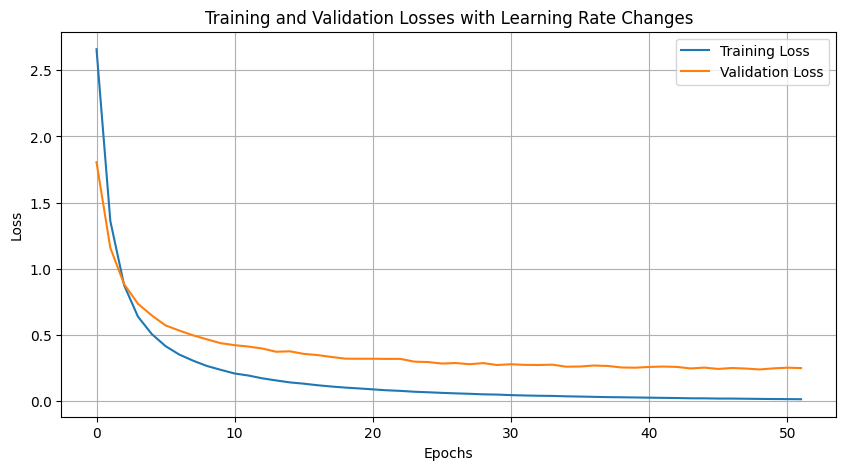

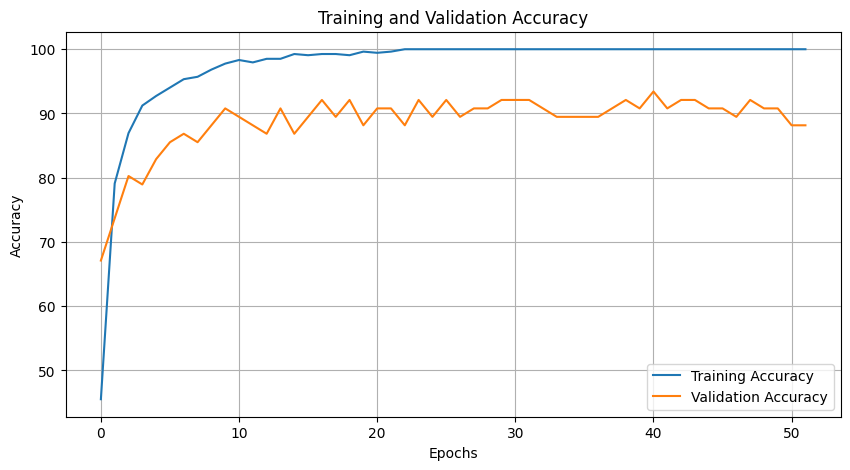

In [8]:
# Plot the training and validation losses with learning rate change points
plt.figure(figsize=(10, 5))
plt.plot(train_losses, label='Training Loss')
plt.plot(val_losses, label='Validation Loss')
for lr_epoch in lr_change_epochs:
    plt.axvline(x=lr_epoch, color='r', linestyle='--', label='LR Change' if lr_epoch == lr_change_epochs[0] else "")
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.title('Training and Validation Losses with Learning Rate Changes')
plt.grid(True)  # Add gridlines
plt.show()

# Plot the training and validation accuracy
plt.figure(figsize=(10, 5))
plt.plot(train_accuracies, label='Training Accuracy')
plt.plot(val_accuracies, label='Validation Accuracy')
for lr_epoch in lr_change_epochs:
    plt.axvline(x=lr_epoch, color='r', linestyle='--', label='LR Change' if lr_epoch == lr_change_epochs[0] else "")
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.title('Training and Validation Accuracy')
plt.grid(True)  # Add gridlines
plt.show()


In [ ]:
# Testing loop
model.eval()  # Set the model to evaluation mode
test_loss = 0.0
correct = 0
total = 0 
with torch.no_grad():
    for inputs, labels in test_loader:
        inputs, labels = inputs.to(device), labels.to(device)  # Move data to GPU
        outputs = model(inputs)
        loss = criterion(outputs.logits, labels)
        test_loss += loss.item()

        _, predicted = torch.max(outputs.logits, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

accuracy = 100 * correct / total
print(f"Test Loss: {test_loss/len(test_loader):.4f}, Test Accuracy: {accuracy:.2f}%")


In [ ]:
import torch
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# Function to test an individual sample and collect predictions and true labels
def test_individual_test_sample(sample_idx, true_labels, predicted_labels):
    # Load a specific sample from the test dataset
    cube, label = test_dataset[sample_idx]
    
    # Move the sample to GPU if using CUDA
    cube = cube.to(device).unsqueeze(0)  # Add batch dimension
    label = label.to(device)
    
    # Set the model to evaluation mode
    model.eval()
    
    # Disable gradient computation for inference
    with torch.no_grad():
        output = model(cube)
    
    # Apply softmax to get probabilities
    probabilities = torch.nn.functional.softmax(output.logits, dim=1)
    
    # Get the predicted class
    predicted_class = torch.argmax(probabilities, dim=1)
    
    # Append the true and predicted labels to their respective lists
    true_labels.append(label.item())
    predicted_labels.append(predicted_class.item())

# Lists to store true and predicted labels
true_labels = []
predicted_labels = []

# Test individual samples and collect labels
for i in range(len(test_dataset)):
    test_individual_test_sample(i, true_labels, predicted_labels)

# Convert lists to numpy arrays for compatibility with sklearn
true_labels = np.array(true_labels)
predicted_labels = np.array(predicted_labels)

# Generate the confusion matrix
cm = confusion_matrix(true_labels, predicted_labels)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)

# Plot the confusion matrix
plt.figure(figsize=(10, 10))
disp.plot(cmap=plt.cm.Blues)
plt.title('Confusion Matrix')
plt.show()


In [ ]:
torch.save(model.state_dict(), 'resnet.pth')

In [ ]:
for name, param in model.named_parameters():
    print(name)

In [ ]:
models.save(

In [ ]:
for a, b in enumerate(train_loader):
    print(a,b)